In [98]:
import numpy as np
from scipy.integrate import simps
from scipy.interpolate import interp1d
from tqdm import trange

import matplotlib.pyplot as plt

import src.datamaker as dm
from importlib import reload
reload(dm)

<module 'src.datamaker' from '/home/b7009348/CosyMAML/src/datamaker.py'>

CDF values: [0.   0.25 0.5  0.75 1.  ]
Bin edges (z): [0.         0.44358868 0.73871146 1.16200649 3.49427104]


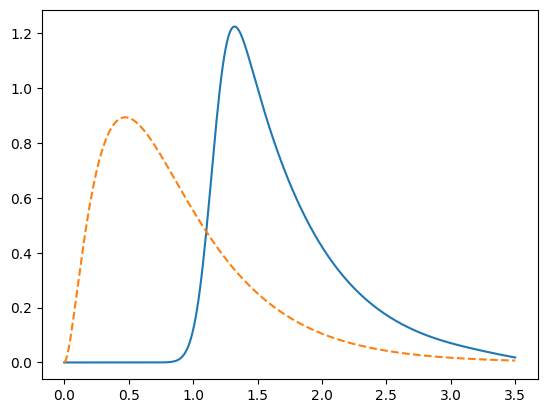

In [94]:
# Generate the redshift distribution
z = np.linspace(0.0, 3.5, 300)
z0 = 0.11
alpha = 0.71

def Smail_dndz(z, z0, alpha):
    return z**2 * np.exp(-(z/z0)**alpha)

dndz_s = Smail_dndz(z, z0, alpha)

# Normalize the distribution
area = simps(dndz_s, z)  # Integrate dndz_s over z to get the area under the curve
pdf = dndz_s / area  # Normalize to make it a PDF

# Compute the cumulative distribution function (CDF)
cdf = np.cumsum(pdf) * (z[1] - z[0])  # Approximate the integral to get the CDF

# Interpolate the CDF to find the bin edges
inverse_cdf = interp1d(cdf, z, fill_value="extrapolate")

n_bins = 4
# Define the CDF values for the bin edges
cdf_values = np.linspace(0, 1, n_bins+1)
print("CDF values:", cdf_values)
# Find the corresponding z values (bin edges) for these CDF values
bin_edges = inverse_cdf(cdf_values)

# Print the bin edges
print("Bin edges (z):", bin_edges)

dndz_ph_bins = []
for i in range(n_bins):
    zs = np.linspace(bin_edges[i], bin_edges[i+1], len(z))
    spec_bin = Smail_dndz(zs, z0, alpha)

    # Convolve with photo-z
    sigma_z = 0.05 * (1 + zs)

    z_ph = np.linspace(0, 3.5, 300)

    # find probability of galaxy with true redshift z_s to be measured at redshift z_ph
    integrand1 = np.zeros([len(zs),len(z_ph)])
    p_zs_zph = np.zeros([len(zs),len(z_ph)])
    for j in range(len(zs)):
        p_zs_zph[j,:] =  (1. / (np.sqrt(2. * np.pi) * sigma_z[j])) * np.exp(-((z_ph - zs[j])**2) / (2. * sigma_z[j]**2))

    integrand1 = p_zs_zph * spec_bin[:,None]   

    # integrate over z_s to get dN
    integral1 = simps(integrand1, zs, axis=0)
    dN = integral1
    
    dz_ph = simps(dN, z_ph)
    dndz_ph_bins.append(dN/dz_ph)

plt.plot(z_ph, dndz_ph_bins[3])
plt.plot(z, pdf, ls='--')

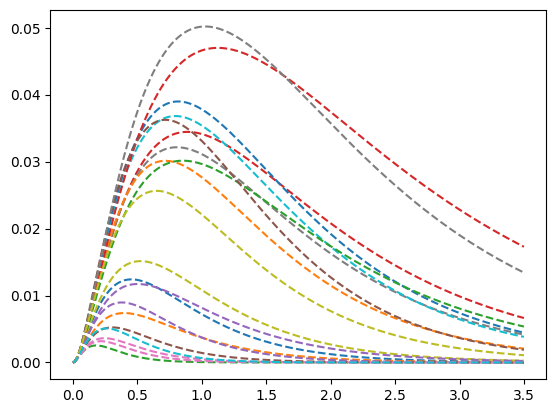

In [78]:
n_tasks = 20

survey_dists = []
for i in range(n_tasks):

    z0 = np.random.uniform(0.05, 0.2)
    alpha = np.random.uniform(0.6, 0.8)

    dndz = Smail_dndz(z, z0, alpha)
    survey_dists.append(dndz)

    plt.plot(z, dndz, ls='--')

- Generate N different survey distributions
- Randomly split distributions into 4 different bins 

CDF values: [0.   0.25 0.5  0.75 1.  ]
Bin edges (z): [0.09915966 0.80211545 1.1006976  1.40971429 2.66666667]


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Text(0, 0.5, 'p(z)')

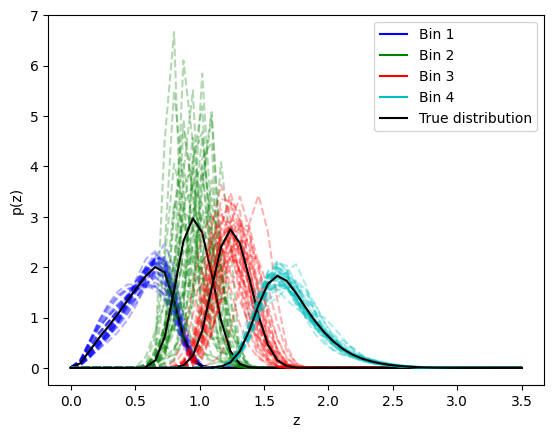

In [134]:
mean = np.random.uniform(0.8, 1.6, 1)
var = np.random.uniform(0.2, 0.6, 1)

gridsize = 50
z = np.linspace(0, 3.5, gridsize)

survey_pz, z = dm.gen_Pz_base(
    mean,
    var,
    grid=z
)

# Normalize the distribution
area = simps(survey_pz, z)  # Integrate dndz_s over z to get the area under the curve
pdf = survey_pz / area  # Normalize to make it a PDF

# Compute the cumulative distribution function (CDF)
cdf = np.cumsum(pdf) * (z[1] - z[0])  # Approximate the integral to get the CDF

# Interpolate the CDF to find the bin edges
inverse_cdf = interp1d(cdf, z, fill_value="extrapolate")

n_bins = 4
# Define the CDF values for the bin edges
cdf_values = np.linspace(0, 1, n_bins+1)
print("CDF values:", cdf_values)

# Find the corresponding z values (bin edges) for these CDF values
bin_edges = inverse_cdf(cdf_values)

# Print the bin edges
print("Bin edges (z):", bin_edges)

n_bins = 4
n_samples = 32
qrd_pz = np.empty((n_bins, n_samples, gridsize-1))
true_means = np.empty((n_bins, n_samples))
c = ['b', 'g', 'r', 'c']
for i in trange(n_bins):
    zs = np.linspace(bin_edges[i], bin_edges[i+1], gridsize)
    spec_bin, zs = dm.gen_Pz_base(
                    mean,
                    var,
                    grid=zs
                )

    # Convolve with photo-z
    sigma_z = 0.05 * (1 + zs)

    z_ph = np.linspace(0, 3.5, len(zs))

    # find probability of galaxy with true redshift z_s to be measured at redshift z_ph
    integrand1 = np.zeros([len(zs),len(z_ph)])
    p_zs_zph = np.zeros([len(zs),len(z_ph)])
    for j in range(len(zs)):
        p_zs_zph[j,:] =  (1. / (np.sqrt(2. * np.pi) * sigma_z[j])) * np.exp(-((z_ph - zs[j])**2) / (2. * sigma_z[j]**2))

    integrand1 = p_zs_zph * spec_bin[:,None]   

    # integrate over z_s to get dN
    integral1 = simps(integrand1, zs, axis=0)
    dN = integral1
    
    dz_ph = simps(dN, z_ph)
    dndz_ph = dN/dz_ph

    qrd_pz[i], true_means[i] = dm.gen_Pz_samples(
                                        dndz_ph,
                                        zs,
                                        seed=14,
                                        shift=0.005,
                                        qrd_samples=n_samples
                                    )
    for j in range(n_samples):
        # Normalize the distributions
        qrd_pz[i,j] /= np.trapz(qrd_pz[i,j], z_ph)
        plt.plot(z_ph, qrd_pz[i, j], ls='--', alpha=0.3, c=c[i])
    plt.plot(z_ph, dndz_ph, c='k')

    # legend with dummy entries
    plt.plot([], [], c=c[i], label=f'Bin {i+1}')

plt.plot([], [], c='k', label='True distribution')
plt.legend()
plt.xlabel('z')
plt.ylabel('p(z)')

In [131]:
bins = np.arange(4)
print(bins)

from itertools import product
combs = list(product(bins, repeat=2))
print(combs)

[0 1 2 3]
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
